In [ ]:
#required packages
!pip install imutils
!pip install scikit-image

## Setup

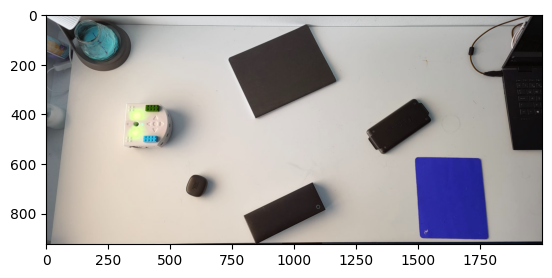

In [44]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

# load images
file_world = 'maps2.jpeg'

# read images as RGB
world = cv2.imread(file_world)
plt.imshow(world)

## 1. Image Smoothing

Parameters:

**d**:Diameter of each pixel neighborhood that is used during filtering.

**sigmaColor**: Filter sigma in the color space. A larger value of the parameter means that farther colors within the pixel neighborhood (see sigmaSpace) will be mixed together, resulting in larger areas of semi-equal color.

**sigmaSpace**: Filter sigma in the coordinate space. A larger value of the parameter means that farther pixels will influence each other as long as their colors are close enough.

For simplicity, sigmaColor and sigmaSpace can be set equal 
[From docs]



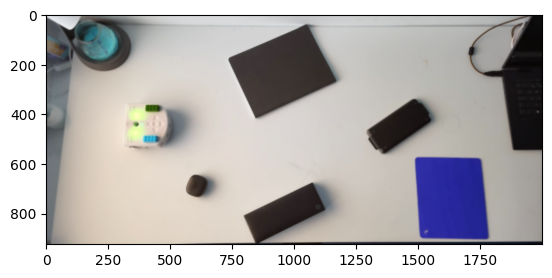

In [45]:
diameter = 10
sc = ss = 300

smooth_world = cv2.bilateralFilter( world,
                                    d=diameter,
                                    sigmaColor = sc,
                                    sigmaSpace = ss)
plt.imshow(smooth_world)


## 2. Image Filtering

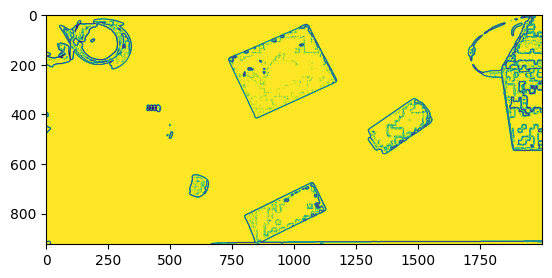

In [5]:
hsv_smooth_world = cv2.cvtColor(smooth_world, cv2.COLOR_RGB2HSV)
max = 80
min = 0
obst_lower = np.array([0,0,min])
obst_upper = np.array([255,255,max])
obst_mask = cv2.inRange(hsv_smooth_world, obst_lower, obst_upper)
result = cv2.cvtColor(cv2.bitwise_and(hsv_smooth_world, hsv_smooth_world, mask = obst_mask), cv2.COLOR_RGB2GRAY)
segmented_world =  cv2.adaptiveThreshold(   src = result, 
                                            maxValue = 255, 
                                            adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            thresholdType = cv2.THRESH_BINARY,
                                            blockSize =11,
                                            C = 2)
plt.imshow(segmented_world)




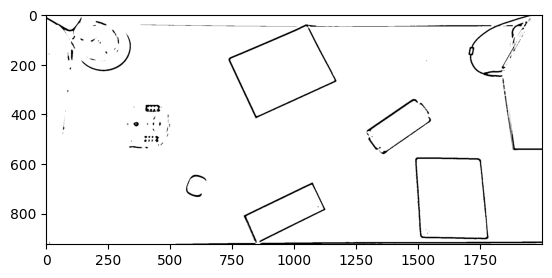

In [46]:
# convert to grayscale
hsv_smooth_world = cv2.cvtColor(smooth_world, cv2.COLOR_RGB2HSV)
gray_smooth_world = cv2.cvtColor(smooth_world, cv2.COLOR_RGB2GRAY)
# create mask
max = 100
min = 0
obst_lower = np.array([min,min,0])
obst_upper = np.array([max,max,0])
obst_mask = cv2.inRange(hsv_smooth_world, obst_lower, obst_upper)


# apply mask
masked_world = cv2.bitwise_and(gray_smooth_world, obst_mask)

# segment the image
segmented_world =  cv2.adaptiveThreshold(   src = gray_smooth_world, 
                                            maxValue = 255, 
                                            adaptiveMethod = cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                            thresholdType = cv2.THRESH_BINARY,
                                            blockSize = 21,
                                            C = 8)

plt.imshow(segmented_world, cmap='gray')

 ## 3. Image Morphological Transformation

Opening, which is a combination of eroding then dilating, is generally used to connect nearby large regions. As we are going to detect 
obstacles, it's better to overestimate their size than underestimating it, therefore we will be using opening. It is also useful for removing noise from the image. We can later apply the morphological gradient transform, so as to keep only the outline of the object.

The type of kernel better suited for this part still needs to be determined


In [1]:
# apply opening morphological operation to remove noise
size1 = 10
size2 = 3
size3 = 30
kernel1 = cv2.getStructuringElement(cv2.MORPH_RECT,(size1,size1))
kernel2 = cv2.getStructuringElement(cv2.MORPH_RECT,(size2,size2))
kernel3 = cv2.getStructuringElement(cv2.MORPH_CROSS,(size3,size3))

filtered_world  = cv2.morphologyEx(segmented_world, cv2.MORPH_OPEN, kernel1)
filtered_world  = cv2.morphologyEx(segmented_world, cv2.MORPH_GRADIENT, kernel2)
#filtered_world  = cv2.morphologyEx(filtered_world, cv2.MORPH_CLOSE, kernel2,iterations=50)


plt.imshow(filtered_world, cmap='gray')

NameError: name 'cv2' is not defined

## 4. Vertex Detection 

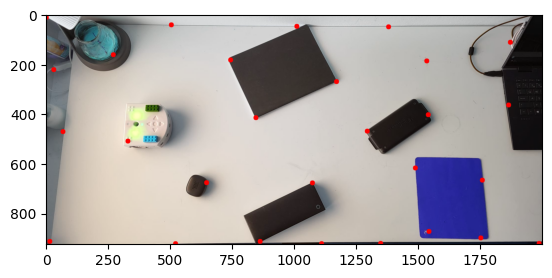

In [24]:
world = cv2.imread(file_world)

vertexes = cv2.goodFeaturesToTrack(  filtered_world,
                                    maxCorners = 50, 
                                    qualityLevel = 0.01, 
                                    minDistance = 200)
vertexes = np.int0(vertexes)

processed_world = world
#plt.imshow(processed_world)

vertexes = np.squeeze(vertexes)

for vertex in vertexes:  # type: ignore
    pos_x,pos_y = vertex.ravel()
    cv2.circle( processed_world,
                (pos_x,pos_y),
                radius = 10,
                color = 255,
                thickness = -1)
    
plt.imshow(processed_world)
plt.show()

## 5. Contour Detection

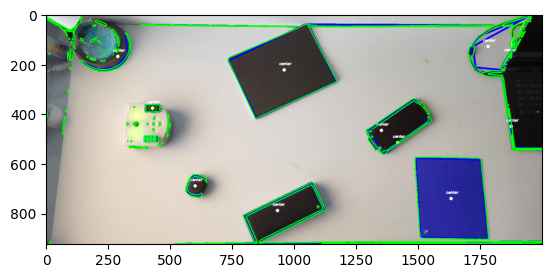

In [43]:
world = cv2.imread(file_world)
processed_world = world
contours, hierarchy = cv2.findContours(filtered_world, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

for contour in contours:
    contour_area = cv2.contourArea(contour)
    

cv2.drawContours(processed_world, contours, -1, (0,255,0), 3)
plt.imshow(processed_world)



## 5. Data Treatment


To gather the points that belong to the same obstacle. We could use KNN means